# Integration with transcriptomics

For this tutorial, we will keep working with the artery datasets from the previous section.

Fortunately, the GTEx dataset also contains RNA-seq paired with histology data. 

Let's first download the RNA seq data in normalized TPM matrix and the image features that we just computed.

In [2]:
from huggingface_hub import hf_hub_download

rna = hf_hub_download("rendeirolab/lazyslide-data", "GTEx_artery_RNA.h5ad", repo_type="dataset")
wsi_features = hf_hub_download("rendeirolab/lazyslide-data", "agg_uni2_features.h5ad", repo_type="dataset")

In [3]:
import anndata as ad
import scanpy as sc

import lazyslide as zs

rna = ad.read_h5ad(rna)
wsi_features = ad.read_h5ad(wsi_features)

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Top-K scoring of calcification

<Axes: xlabel='Pathology Categories', ylabel='calcification'>

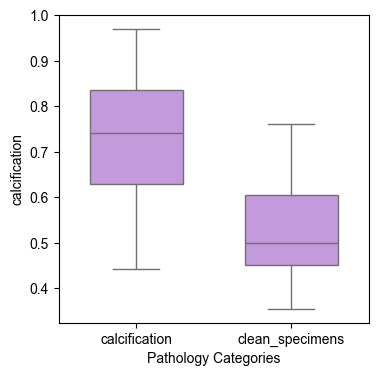

In [4]:
import seaborn as sns

sns.boxplot(
    data=wsi_features.obs,
    x="Pathology Categories",
    y="calcification",
    color="#C68FE6",
    width=0.6,
)

## Visualization of RNA and histology morphological features

In [5]:
def run_umap(adata):
    sc.pp.scale(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

run_umap(rna)
run_umap(wsi_features)

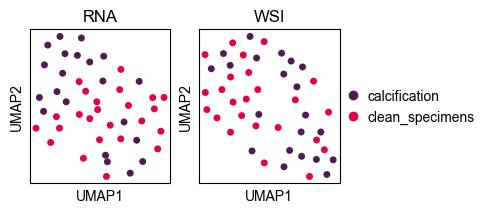

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(4, 2))
opts = dict(
    color="Pathology Categories", palette=["#4F1C51", "#E50046"], size=100, show=False
)

sc.pl.umap(rna, ax=axes[0], legend_loc=None, **opts)
sc.pl.umap(wsi_features, ax=axes[1], **opts)
axes[0].set_title("RNA")
axes[1].set_title("WSI")
plt.show(fig)

## Link the two modalities

In [7]:
linker = zs.tl.RNALinker(wsi_features, rna)

In [8]:
linker.associate(method="spearman", score_key="calcification")

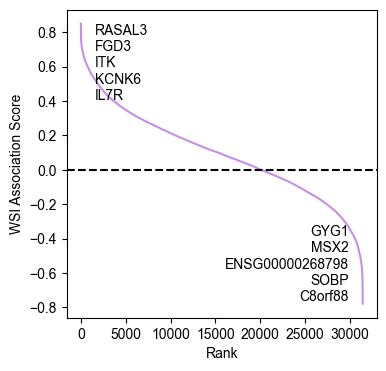

In [9]:
linker.plot_rank(gene_name="Description")

Getting genes that associated with morphological features

In [10]:
genes = linker.associated_genes(100, gene_name="Description")

Let's performe GO analysis

In [11]:
import gseapy as gp

opts = dict(
    gene_sets=["MSigDB_Hallmark_2020", "KEGG_2021_Human", "GO_Biological_Process_2025"],
    organism="Human",
    background=rna.var["Description"].to_list(),
    outdir=None,
)

up_enr = gp.enrichr(gene_list=list(genes["top"].index), **opts)
down_enr = gp.enrichr(gene_list=list(genes["bottom"].index), **opts)

### Code for visualize the result of GO terms

In [12]:
def plot_ora(up_enr, down_enr, n=10):
    import matplotlib.pyplot as plt
    import mpl_fontkit as fk

    fk.install("Lato", verbose=False)

    _, ax = plt.subplots(figsize=(3, 5))

    sort_k = "Combined Score"
    cols = ["Term", "Combined Score"]

    up_r = up_enr.results.sort_values(sort_k, ascending=False).head(n)[cols]
    down_r = down_enr.results.sort_values(sort_k, ascending=False).head(n)[cols]
    down_r[sort_k] = -down_r[sort_k]
    down_r = down_r.iloc[::-1]

    # Plot bars
    ax.barh(up_r["Term"], up_r[sort_k], color="#E73879", label="Up-reg Terms")
    ax.barh(down_r["Term"], down_r[sort_k], color="#009990", label="Down-reg Terms")

    # Add annotations for terms
    for direction, data, offset, align in [
        ("up", up_r, -3, "right"),
        ("down", down_r, 3, "left"),
    ]:
        for term in data["Term"]:
            ax.annotate(
                term,
                xy=(0, term),
                xytext=(offset, 0),
                textcoords="offset points",
                va="center",
                ha=align,
                fontsize=8,
            )

    # Finalize plot aesthetics
    ax.invert_yaxis()
    ax.axvline(0, color="k", lw=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.tick_params(left=False, labelleft=False)
    ax.legend(ncol=2, loc="upper center", bbox_to_anchor=(0, 0.01))

### Visualize the result of GO terms

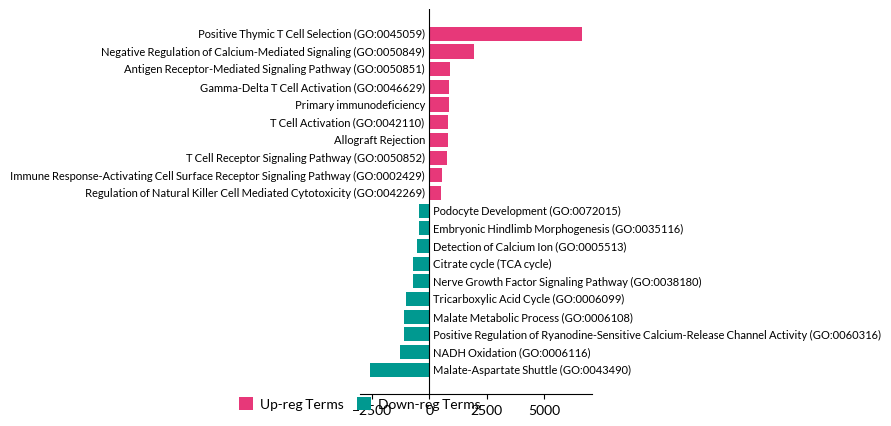

In [13]:
plot_ora(up_enr, down_enr)

In [14]:
import scanpy as sc

N_genes = 100

sc.tl.rank_genes_groups(rna, "Pathology Categories", method="wilcoxon")
de_list = list(
    sc.get.rank_genes_groups_df(rna, "calcification").sort_values("scores")["names"]
)
up_de = de_list[0:N_genes]
down_de = de_list[-N_genes::]

de_list = up_de + down_de

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [15]:
up_enr = gp.enrichr(gene_list=rna.var.loc[up_de]["Description"].to_list(), **opts)
down_enr = gp.enrichr(gene_list=rna.var.loc[down_de]["Description"].to_list(), **opts)

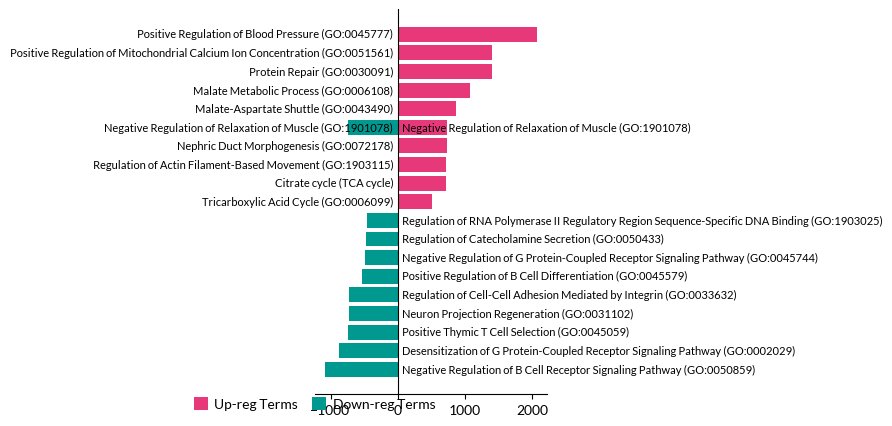

In [16]:
plot_ora(up_enr, down_enr)

## MOFA

A classical approach for multi-modalities analysis is [MOFA](https://www.embopress.org/doi/full/10.15252/msb.20178124).

In [17]:
wsi_features.obs = wsi_features.obs.set_index("Tissue Sample Id")

In [18]:
import muon as mu

mdata = mu.MuData({"wsi": wsi_features, "rna": rna})

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [19]:
mu.tl.mofa(mdata, verbose=False)

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/mofapy2/run/entry_point.py:66: SyntaxWarning: invalid escape sequence '\/'
  banner = """
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/mofapy2/core/utils.py:50: SyntaxWarning: invalid escape sequence '\m'
  """Diagonal of :math:`\mathrm A\mathrm B^\intercal`.
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/mofapy2/core/distributions/multivariate_gaussian.py:243: SyntaxWarning: invalid escape sequence '\ '
  """
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/mofapy2/core/nodes/nongaussian_nodes.py:169: SyntaxWarning: invalid escape sequence '\p'
  """
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/mofapy2/core/nodes/Sigma_node.py:28: SyntaxWarning: invalid escape sequence '\o'
  """



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='wsi' group='group1' with N=45 samples and D=1536 features...
Loaded view='rna' group='group1' with N=45 samples and D=31439 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True


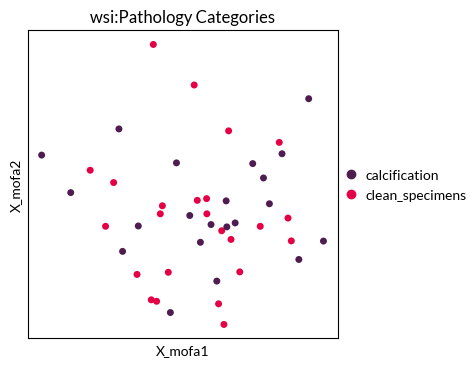

In [20]:
mu.pl.mofa(
    mdata, color="wsi:Pathology Categories", palette=["#4F1C51", "#E50046"], size=100
)

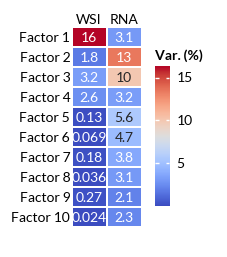

In [21]:
import numpy as np
import marsilea as ma

loadings = mdata.uns["mofa"]["variance"]

h = ma.Heatmap(
    np.array([loadings["wsi"], loadings["rna"]]).T,
    annot=True,
    cbar_kws={"width": 1, "height": 10},
    width=0.7,
    height=2,
    linewidth=0.1,
    label="Var. (%)",
)
h.add_top(ma.plotter.Labels(["WSI", "RNA"], rotation=0))
h.add_left(ma.plotter.Labels([f"Factor {i}" for i in np.arange(10) + 1]))
h.add_legends(box_padding=1)
h.render()